# Script to scan the PSSS crystal height
### Purpose:
The PSSS signal level is very sensitive to the crystal height.  This script will scan the height and set the position to the maximum signal

Contact christopher.arrell@psi.ch

In [36]:
import epics as ep
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from collections import deque
from scipy.optimize import curve_fit
%matplotlib inline
from IPython.display import clear_output, display

## Setup and functions setup

In [10]:
PSSS_spectrum_name = 'SARFE10-PSSS059:SPECTRUM_Y'
PSSS_e_axis_name = 'SARFE10-PSSS059:SPECTRUM_X'
PSSS_xstal_height_name = 'SARFE10-PSSS059:MOTOR_Y3.VAL'

PSSS_spectrum_PV = ep.PV(PSSS_spectrum_name)
PSSS_e_axis_PV = ep.PV(PSSS_e_axis_name)
PSSS_xstal_height_PV = ep.PV(PSSS_xstal_height_name)

def set_xstal_height(pos):
    PSSS_xstal_height_PV.put(pos, wait=True)

def PSSS_xstal_height_scan(Energy_range, NumShots):
        
    Spectrum_scan = []
            
    for pos in xstal_range:
        set_xstal_height(pos)
        sleep(2)
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PSSS_spectrum_PV.add_callback(callback=on_value_change, pv =PSSS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        Spectrum_scan.append(np.array(Spectrum_this_energy))
        
    return(np.array(Spectrum_scan))

def gaus(x,a,x0,sigma,offset):
    return offset +a*np.exp(-(x-x0)**2/(2*sigma**2))

## User inputs - define travel range of crystal
It is unlikely these values need to be changed

In [58]:
xstal_from = -0.8
xstal_to = -1.7
steps = 30
NumShots= 300
xstal_range = np.linspace(xstal_from, xstal_to, steps)

## Scan and take data

In [59]:
Scan_spec = PSSS_xstal_height_scan(xstal_range,NumShots)

## Plot and return maxium position


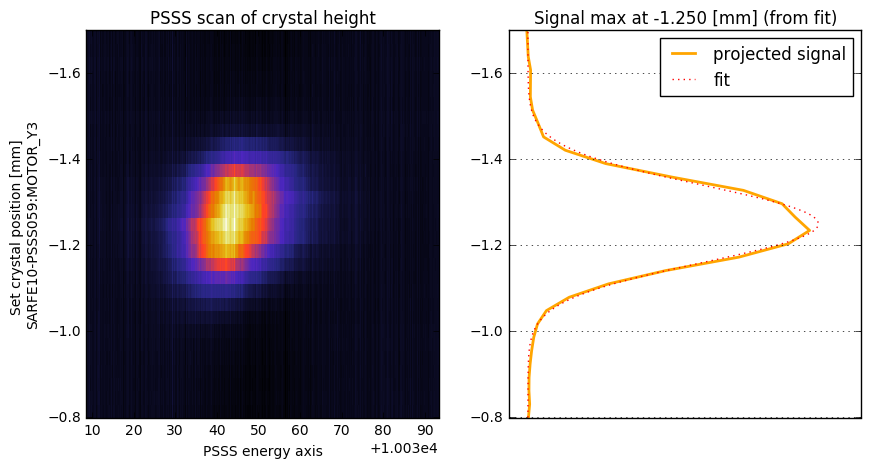

In [64]:
projection = Scan_spec.mean(axis=1).mean(axis=1)
signal_centre = xstal_range[np.argmax(projection)]
xstal_range_fit = np.linspace(xstal_range[0], xstal_range[-1], len(xstal_range)*10)

try:
    popt,pcov = curve_fit(gaus,xstal_range,projection,p0=[100,signal_centre,-0.2,100])
except:
    print('Fit failed: spectrum might not be near scan range center')
    popt = [0.0, 0.0, 0.0, 0.0]
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('PSSS scan of crystal height')
plt.pcolormesh(energy_axis, xstal_range, Scan_spec.mean(axis=1),cmap='CMRmap')
plt.xlim([energy_axis[0],energy_axis[-1]])
plt.ylim([xstal_range[0], xstal_range[-1]])
plt.xlabel('PSSS energy axis')
plt.ylabel('Set crystal position [mm] \n'+PSSS_xstal_height_name[0:-4])
plt.subplot(122)
plt.plot(projection,xstal_range,linewidth = 2, color = 'orange',label ='projected signal')
plt.plot(gaus(xstal_range_fit,*popt),xstal_range_fit,'r:',label='fit')
plt.ylim([xstal_range[0], xstal_range[-1]])
plt.title('Signal max at %.3f [mm] (from fit)'%popt[1])
plt.xticks([])
plt.legend()
plt.grid(True)

## Set max position
Cell below will push the maximum position to the xstal height

In [61]:
set_xstal_height(popt[1])